# Model Definition Notebook

Install the proper version of tensorFlow and Keras packages

In [1]:
!pip install --upgrade keras-applications keras-preprocessing setuptools tensorflow==1.14.0 keras==2.2.5

     |████████████████████████████████| 51kB 13.4MB/s eta 0:00:01
     |████████████████████████████████| 51kB 20.1MB/s eta 0:00:01
     |████████████████████████████████| 583kB 21.6MB/s eta 0:00:01
     |████████████████████████████████| 109.2MB 263kB/s  eta 0:00:01
     |████████████████████████████████| 337kB 44.7MB/s eta 0:00:01
     |████████████████████████████████| 61kB 26.7MB/s eta 0:00:01
     |████████████████████████████████| 3.2MB 47.6MB/s eta 0:00:01
     |████████████████████████████████| 491kB 48.2MB/s eta 0:00:01
  Found existing installation: Keras-Applications 1.0.6
    Uninstalling Keras-Applications-1.0.6:
      Successfully uninstalled Keras-Applications-1.0.6
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing i

In [3]:
import tensorflow
if not tensorflow.__version__ == '1.14.0':
    print(tensorflow.__version__)
    raise ValueError('please upgrade to TensorFlow 1.14.0, or restart your Kernel (Kernel->Restart & Clear Output)')

import keras
if not keras.__version__ == '2.2.5':
    print(keras.__version__)
    raise ValueError('please upgrade to Keras 2.2.5, or restart your Kernel (Kernel->Restart & Clear Output)')

Import libraries

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pickle

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import *
from keras.activations import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend
from keras.models import model_from_json

from botocore.client import Config
import ibm_boto3

Define credentials to access a IBM cloud bucket storage

In [6]:
# The code was removed by Watson Studio for sharing.

Load the training, validation and testing data

In [7]:
# load data
dataset = 'data_shuffled_scaled255.pickle'
cos.download_file(Bucket=credentials['BUCKET'], Key=dataset, Filename=dataset) 

with open(dataset, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# transpose for images 32 x 32 x 3    
x_train = data['x_train'].transpose(0, 2, 3, 1)
x_validation = data['x_validation'].transpose(0, 2, 3, 1)
x_test = data['x_test'].transpose(0, 2, 3, 1)

#labels
labels = data['labels']

# shapes of pictures
height = x_train.shape[1]
width = x_train.shape[2]
depth = x_train.shape[3]
        
#sizes     
train_size = data['x_train'].shape[0]
validation_size = data['x_validation'].shape[0]
test_size = data['x_test'].shape[0]      
num_classes = data['labels'].shape[0] 

# One hot encoding
y_train = to_categorical(data['y_train'], num_classes=num_classes)
y_validation = to_categorical(data['y_validation'], num_classes=num_classes)
y_test = to_categorical(data['y_test'], num_classes=num_classes)

# Display shapes
print("x_train: ", x_train.shape)
print("x_validation: ", x_validation.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_validation: ", y_validation.shape)
print("y_test: ", y_test.shape)

x_train:  (86989, 32, 32, 3)
x_validation:  (4410, 32, 32, 3)
x_test:  (12630, 32, 32, 3)
y_train:  (86989, 43)
y_validation:  (4410, 43)
y_test:  (12630, 43)


We define a Logistics Regression Model with Keras. In this case we only need to flatten the input layer in order that the input shape of 32 x 32 x 3 becomes a single vector of 3072 features, and create a single layer with a softmax activation as all the classes are mutually exclusive

In [8]:
# Define the Logistics Regression Model
def create_model(optimizer, lr, width, height, depth, num_classes):
    
    input_img = Input(shape=(width, height, depth))   

    x = Flatten()(input_img)
    x = Dense(num_classes)(x)
    output_pred = Activation("softmax")(x)
   
    optimizer = optimizer(lr=lr)
    model = Model(inputs=input_img, outputs=output_pred)
    model.compile(
        loss="categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"])
    model.summary()
    
    return model

We define hyperparameters using a very common setup

In [13]:
# hyperparameter
lr = 1e-3
optimizer = Adam
batch_size = 8
epochs = 15

In [10]:
# create model
model = create_model(optimizer, lr, width, height, depth, num_classes)

W1021 13:30:02.691947 140300642330432 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1021 13:30:02.731636 140300642330432 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 13:30:02.749659 140300642330432 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1021 13:30:02.794319 140300642330432 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                132139    
_________________________________________________________________
activation_1 (Activation)    (None, 43)                0         
Total params: 132,139
Trainable params: 132,139
Non-trainable params: 0
_________________________________________________________________


In [11]:
# define learning rate sheduler
def schedule(epoch):
    lr = 0.001/(epoch+1)

    return lr

lrs = LearningRateScheduler(
    schedule=schedule,
    verbose=1)

In [12]:
# training
history = model.fit(
    x=x_train, 
    y=y_train, 
    verbose=1, 
    #batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(x_validation, y_validation),
    callbacks=[lrs])

W1021 13:30:18.017089 140300642330432 deprecation.py:323] From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1021 13:30:18.067610 140300642330432 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 86989 samples, validate on 4410 samples
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
86989/86989 [==============================] - 27s 312us/step - loss: 1.6490 - acc: 0.6593 - val_loss: 1.2893 - val_acc: 0.7039
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005.
86989/86989 [==============================] - 27s 313us/step - loss: 0.9696 - acc: 0.8335 - val_loss: 1.1595 - val_acc: 0.7347
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003333333333333333.
86989/86989 [==============================] - 27s 311us/step - loss: 0.8301 - acc: 0.8630 - val_loss: 1.0213 - val_acc: 0.7800
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.00025.
86989/86989 [==============================] - 27s 305us/step - loss: 0.7596 - acc: 0.8779 - val_loss: 0.9898 - val_acc: 0.7757
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 0.0002.
86989/86989 [===========

We save the keras model and weights for later use

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open('model_logisticsRegression.json', "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model_logisticsRegression.h5')

#upload feather object
cos.upload_file(Filename='model_logisticsRegression.json', Bucket=credentials['BUCKET'], Key='model_logisticsRegression.json') 
cos.upload_file(Filename='model_logisticsRegression.h5', Bucket=credentials['BUCKET'], Key='model_logisticsRegression.h5') 

print("Saved model to disk")

Saved model to disk


We save the history of the training fit of the model that includes the loss and metrics for every epoch, for plotting later without training the dataset again

In [14]:
with open('model_logisticsRegression_history.pickle', 'wb') as f:
    pickle.dump(history, f)
    
cos.upload_file(Filename='model_logisticsRegression_history.pickle', Bucket=credentials['BUCKET'], Key='model_logisticsRegression_history.pickle') 

We load the model again with the weights

In [13]:
# load json and create model

cos.download_file(Bucket=credentials['BUCKET'], Key='model_logisticsRegression.json', Filename='model_logisticsRegression.json')
cos.download_file(Bucket=credentials['BUCKET'], Key='model_logisticsRegression.h5', Filename='model_logisticsRegression.h5')

with open("model_logisticsRegression.json", "r") as json_file:
    loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_logisticsRegression.h5")

print("Loaded model from disk")

Loaded model from disk


We load the history with the loss and the metrics obtained during trainig

In [15]:
cos.download_file(Bucket=credentials['BUCKET'], Key='model_logisticsRegression_history.pickle', Filename='model_logisticsRegression_history.pickle') 

with open('model_logisticsRegression_history.pickle', 'rb') as file:
    history = pickle.load(file, encoding='latin1')

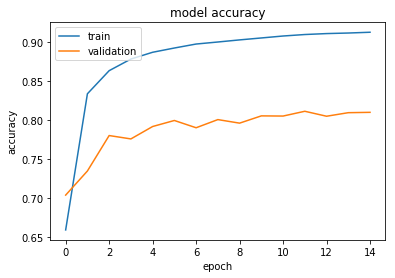

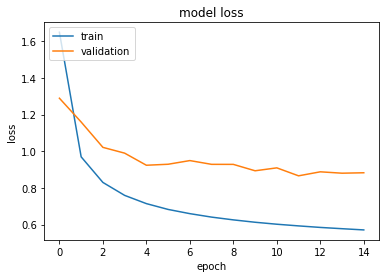

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
# score on test data
score = model.evaluate(x_test, y_test)
print("Test performance- Loss: ", score[0])
print("Test performance- Accuracy: ", score[1])

12630/12630 [==============================] - 1s 75us/step
Test performance- Loss:  0.8806557306106942
Test performance- Accuracy:  0.8098178939411589


In [18]:
# store wrong predictions

pred = model.predict(x_test)

# init
wrong = np.array([])

for k in range(pred.shape[0]):
    ClassId_pred = np.argmax(pred[k])
    ClassId_true= np.argmax(y_test[k])
    if ClassId_pred != ClassId_true: 
        wrong = np.append(wrong, k)
        
print("Number of wrong predictions: ", wrong.size)
print("Percentage if wrong predictions: {0:.3f}".format((wrong.size/pred.shape[0])*100), "%")

Number of wrong predictions:  2402
Percentage if wrong predictions: 19.018 %


Show some examples of wrong preditions

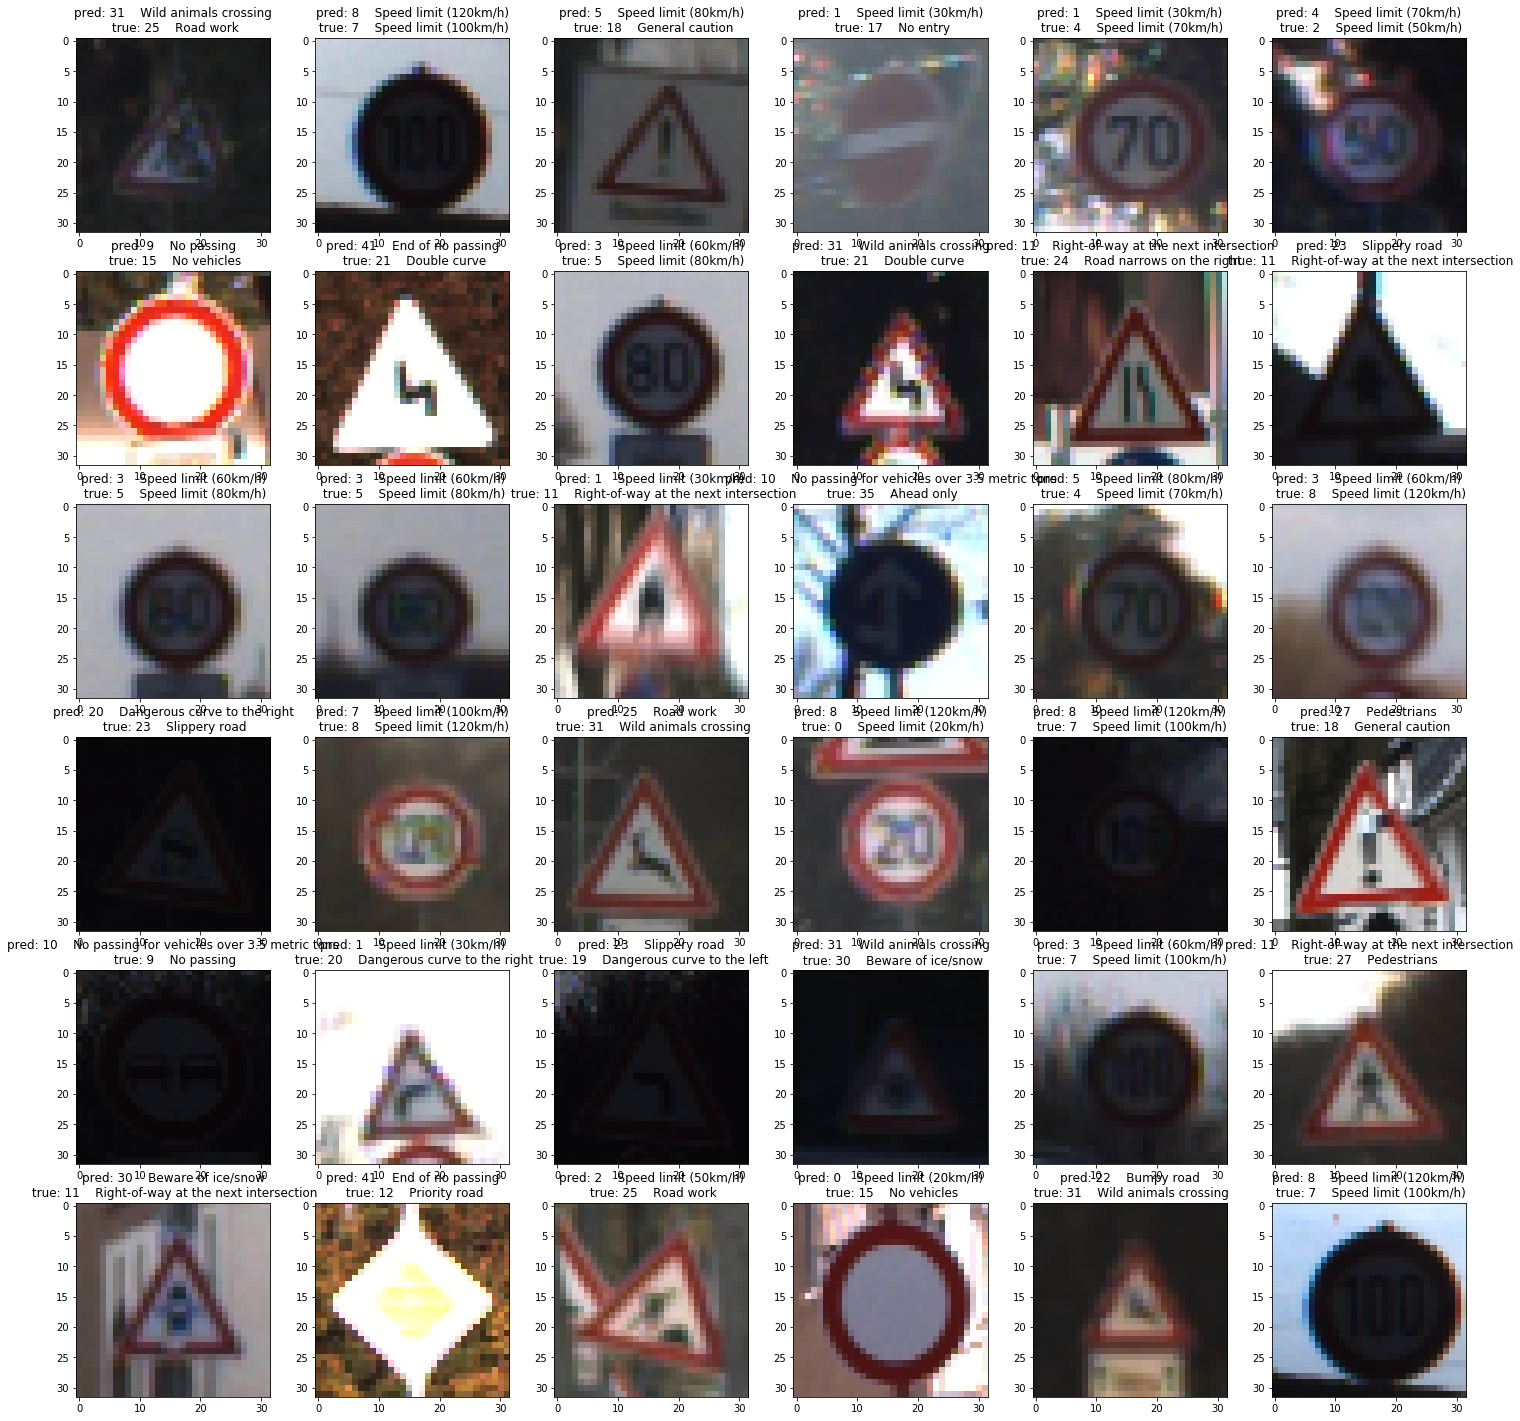

In [19]:
# show example images
rows = 6
cols = 6

fig, axs = plt.subplots(rows,cols, figsize = (25,25))

for i in range(rows):
    for j in range(cols):
            ClassId_pred = np.argmax(pred[int(wrong[rows*i+j])])
            label_pred = labels[labels["ClassId"] == ClassId_pred]["SignName"].to_string()
            ClassId_true= np.argmax(y_test[int(wrong[rows*i+j])])
            label_true = labels[labels["ClassId"] == ClassId_true]["SignName"].to_string()
            axs[i,j].imshow(x_test[int(wrong[rows*i+j])])
            axs[i,j].set_title("pred: "+label_pred+"\n true: "+label_true)
    
fig.show()